In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from cloud_detection import *
from sun_position_identification import *
import cv2
from matplotlib.animation import FuncAnimation
from IPython.display import Video

In [3]:
# define data path
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
data_folder = os.path.join(pardir, "data")
output_folder = os.path.join(pardir,"figs")

time_sunny_path = os.path.join(data_folder,'time_stamps_sunny.npy')
img_sunny_path = os.path.join(data_folder,'sky_images_sunny.npy')

time_cloudy_path = os.path.join(data_folder,'time_stamps_cloudy.npy')
img_cloudy_path = os.path.join(data_folder,'sky_images_cloudy.npy')

# import data
time_stamps_sunny = np.load(time_sunny_path,allow_pickle=True)
sky_images_sunny = np.load(img_sunny_path,allow_pickle=True)

print("time_stamps_sunny shape: ", time_stamps_sunny.shape)
print("sky_images_sunny shape: ", sky_images_sunny.shape)

time_stamps_cloudy = np.load(time_cloudy_path,allow_pickle=True)
sky_images_cloudy = np.load(img_cloudy_path,allow_pickle=True)

print("time_stamps_cloudy shape: ", time_stamps_cloudy.shape)
print("sky_images_cloudy shape: ", sky_images_cloudy.shape)

time_stamps_sunny shape:  (1779,)
sky_images_sunny shape:  (1779, 64, 64, 3)
time_stamps_cloudy shape:  (1605,)
sky_images_cloudy shape:  (1605, 64, 64, 3)


## Demo single image

In [4]:
def vis_single_img(time_stamp,image):
    
    '''
    Visualization of cloud detection result for a single sky image
    '''

    # run cloud_detection function
    cloud_cover,cloud_mask,sun_mask = cloud_detection(time_stamp,image)
    #sun_center_x, sun_center_y, _ = sun_position(time_stamp)

    # cloud detection result visualization
    f,ax = plt.subplots(1,2)

    ## original image
    ax[0].imshow(image[:,:,::-1])
    #ax[0].set_title(time_stamp)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image')
    
    ## cloud detection result
    ### calculate the morphological gradient for cloud mask to draw the edge to the clouds
    kernel = np.ones((2,2), np.uint8)
    bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

    ax[1].imshow(image[:,:,::-1], interpolation='none')
    ax[1].imshow(sun_mask, interpolation='none', alpha=0.15)
    ax[1].imshow(cloud_mask, interpolation='none', alpha=0.1)
    ax[1].imshow(bound_cloud, interpolation='none', alpha=0.2)
    #ax[1].set_title(time_stamp)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result') 
    #ax[1].text(1.1,0.8,'Sun poisition: ({0},{1})'.format(sun_center_x,sun_center_y),transform=ax[1].transAxes)
    ax[1].text(0.25,0.025,'Cloud fraction={0:.2f}'.format(cloud_cover),color='white',transform=ax[1].transAxes)

    f.tight_layout()
    plt.show()

### demo 1: sun position identification
Sun position is indicated by red pixels

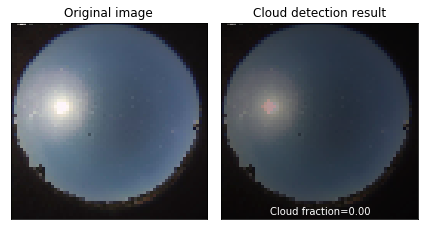

In [5]:
sample_num = 100
img = sky_images_sunny[sample_num]
time_stamp = time_stamps_sunny[sample_num]
vis_single_img(time_stamp,img)

### demo 2: cloud detection
Clouds are indicated by green pixels

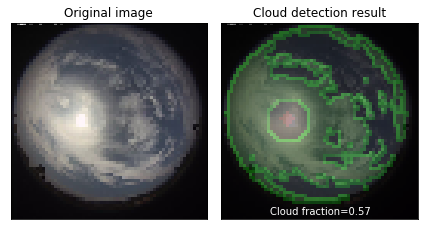

In [10]:
# demo 2: one sample from cloudy day
sample_num = 200
img = sky_images_cloudy[sample_num]
time_stamp = time_stamps_cloudy[sample_num]
vis_single_img(time_stamp,img)

## Demo image time series

In [11]:
def vis_img_ts(time_stamps,images):
    '''
    Visualization of cloud detection results for image time series
    Generating a video
    '''
    
    # define a images_overlay variable that store original images and cloud detection results
    images_overlay = np.zeros_like(images)
    cloud_cover_arr = np.zeros(len(time_stamps))
    
    # run cloud detection function and overlay results with original images 
    for i in range(len(time_stamps)):
        # run cloud_detection function
        cloud_cover,cloud_mask,sun_mask = cloud_detection(time_stamps[i],images[i])
        cloud_cover_arr[i] = cloud_cover

        # calculate the morphological gradient for cloud mask to draw the edge to the clouds
        kernel = np.ones((2,2), np.uint8)
        bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

        alpha1=0.15
        images_overlay[i] = cv2.addWeighted(images[i], 1-alpha1, sun_mask[:,:,::-1], alpha1, 0)

        alpha2=0.1
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha2, cloud_mask, alpha2, 0)
        
        alpha3=0.2
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha3, bound_cloud, alpha3, 0)
    
    f, ax = plt.subplots(1,2)
    img_plot1 = ax[0].imshow(images[0,:,:,::-1])
    img_plot2 = ax[1].imshow(images_overlay[0,:,:,::-1])
    cloud_fraction_text = ax[1].text(0.25,0.025, '', color='white', transform=ax[1].transAxes)
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image',fontsize=8)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result',fontsize=8)

    f.tight_layout()

    def update(frame_idx):
        # Update the image data for each frame
        img_plot1.set_data(images[frame_idx,:,:,::-1])
        img_plot2.set_data(images_overlay[frame_idx,:,:,::-1])

        # Update text elements
        cloud_fraction_text.set_text('Cloud fraction={0:.2f}'.format(cloud_cover_arr[frame_idx]))

        return [img_plot1, img_plot2, cloud_fraction_text]

    # Create the animation
    ani = FuncAnimation(f, update, frames=len(time_stamps), interval=50, blit=True)
    
    plt.close(f)

    return ani

### demo 3: sun position identification 

In [16]:
dates_sunny = np.asarray([time.date() for time in time_stamps_sunny])
np.unique(dates_sunny)

array([datetime.date(2017, 5, 20), datetime.date(2017, 8, 19),
       datetime.date(2017, 10, 7)], dtype=object)

In [18]:
# select 1 sunny_day for demonstration of sun position identification algortihm
select_sunny_day = [datetime.date(2017, 5, 20)]

mask_select_sunny_day = np.zeros(len(time_stamps_sunny),dtype=bool)
for i in range(len(time_stamps_sunny)):
    if dates_sunny[i] in select_sunny_day:
        mask_select_sunny_day[i] = 1

time_stamps_select_sunny_day = time_stamps_sunny[mask_select_sunny_day]
sky_images_select_sunny_day = sky_images_sunny[mask_select_sunny_day]
print('time_stamps_select_sunny_day.shape:',time_stamps_select_sunny_day.shape)
print('sky_images_select_sunny_day.shape:',sky_images_select_sunny_day.shape)

time_stamps_select_sunny_day.shape: (599,)
sky_images_select_sunny_day.shape: (599, 64, 64, 3)


In [19]:
# demo 3: sun position identification for one sunny day, sample image every 2 minutes to save time
ani = vis_img_ts(time_stamps_select_sunny_day[::2],sky_images_select_sunny_day[::2])
ani.save(os.path.join(output_folder,'cloud_detection_ts_sunny.mp4'), dpi =300)

In [20]:
Video(os.path.join(output_folder,'cloud_detection_ts_sunny.mp4'))

### demo 4: cloud detection

In [ ]:
dates_cloudy = np.asarray([time.date() for time in time_stamps_cloudy])
np.unique(dates_cloudy)

array([datetime.date(2017, 5, 24), datetime.date(2017, 9, 6),
       datetime.date(2017, 12, 29)], dtype=object)

In [29]:
# select 1 cloudy_day for demonstration of cloud detection algorithm
select_cloudy_day = [datetime.date(2017, 5, 24)]
mask_select_cloudy_day = np.zeros(len(time_stamps_cloudy),dtype=bool)
for i in range(len(time_stamps_cloudy)):
    if dates_cloudy[i] in select_cloudy_day:
        mask_select_cloudy_day[i] = 1

time_stamps_select_cloudy_day = time_stamps_cloudy[mask_select_cloudy_day]
sky_images_select_cloudy_day = sky_images_cloudy[mask_select_cloudy_day]
print('time_stamps_select_cloudy_day.shape:',time_stamps_select_cloudy_day.shape)
print('sky_images_select_cloudy_day.shape:',sky_images_select_cloudy_day.shape)

time_stamps_select_cloudy_day.shape: (600,)
sky_images_select_cloudy_day.shape: (600, 64, 64, 3)


In [30]:
# demo 3: cloud detection for one cloudy day, sample image every 2 minutes to save time
ani = vis_img_ts(time_stamps_select_cloudy_day[::2],sky_images_select_cloudy_day[::2])
ani.save(os.path.join(output_folder,'cloud_detection_ts_cloudy.mp4'), dpi =300)

In [28]:
Video(os.path.join(output_folder,'cloud_detection_ts_cloudy.mp4'))